In [1]:
import torch
import sys
import torch
import os.path as osp
import tqdm
import sys
import numpy as np
sys.path.append('/afs/cern.ch/work/m/mgarciam/private/mlpf/')
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
import dgl
from sklearn.decomposition import PCA


/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args:
    def __init__(self):
        self.data_train = ["/afs/cern.ch/work/g/gkrzmanc/public/ClicDet_v1_25_07_2023_full.root"]
        self.data_val = ['/afs/cern.ch/work/g/gkrzmanc/public/ClicDet_v1_25_07_2023_full.root']
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/m/mgarciam/private/mlpf/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False
args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')

In [3]:
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                   extra_selection=args.extra_selection,
                                   remake_weights= True,
                                   load_range_and_fraction=(train_range, args.data_fraction),
                                   file_fraction=args.file_fraction,
                                   fetch_by_files=args.fetch_by_files,
                                   fetch_step=args.fetch_step,
                                   infinity_mode= False,
                                   in_memory=args.in_memory,
                                   async_load = False,
                                   name='train', dataset_cap=None)

In [4]:
train_data._data_config.graph_config["only_hits"] = True

In [5]:
iterator = iter(train_data)

=== Restarting DataIter train, seed=None ===


In [6]:
g, y = next(iterator)

In [7]:
print(np.unique(torch.argmax(g.ndata['hit_type'],dim=1)))


[2 3]


In [8]:
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=10, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)

In [9]:
iterator = iter(train_loader)
g, y = next(iterator)


=== Restarting DataIter train, seed=None ===


In [10]:
from src.models.wrapper.example_gravnet_model import GraphTransformerNetWrapper
model = GraphTransformerNetWrapper('cpu',output_dim =4, n_postgn_dense_blocks=4)


new_model = "/afs/cern.ch/work/m/mgarciam/private/models/test_mlpf_qmin/_epoch-0_state.pt"  # 16D clustering space

new_model = "/eos/user/g/gkrzmanc/mlpf_data/tanh_hits_only_model_3D_clust_space_fix_2807_with_clust_loss_epoch-0_state.pt"
# old_model = "/eos/user/g/gkrzmanc/mlpf_data/25_07_2023/_epoch-48_state.pt"  # old model

# new_model_2 = "/eos/home-g/gkrzmanc/mlpf_data/25_07_2023_norm_knn_FULL_10k_32Dim_clustering/_epoch-20_state.pt"  # 32 dim clustering
# new_model_3 = "/eos/home-g/gkrzmanc/mlpf_data/25_07_2023_norm_knn_FULL_10k_1BLOCK_1/_epoch-9_state.pt"  # only 1 block of post-gravnet dense

# new_model_4 = "/eos/home-g/gkrzmanc/mlpf_data/k_zero_debug_260723_1/_epoch-6_state.pt"

# new_model_5 = "/eos/home-g/gkrzmanc/mlpf_data/overfit_test_debug_260723_1/_epoch-12_state.pt"   # overfitting with 10 events
# overfit_model = "/eos/home-g/gkrzmanc/mlpf_data/overfit-1-event/_epoch-244_state.pt"

# new_model_hits_only = "/eos/home-g/gkrzmanc/mlpf_data/hits_only_model_260723/_epoch-171_state.pt"

# no_bn_hits_only_27_07 = "/eos/home-g/gkrzmanc/mlpf_data/hits_only_27_07_no_bn/_epoch-14_state.pt"

# #hits_only_27_07 = "/eos/home-g/gkrzmanc/mlpf_data/hits_only_27_07/_epoch-21_state.pt"


model.load_state_dict(torch.load(new_model, map_location='cpu'))

<All keys matched successfully>

In [11]:
pred, grapsh = model(g)

In [12]:
graph_list = dgl.unbatch(g)

In [13]:
len(grapsh)

4

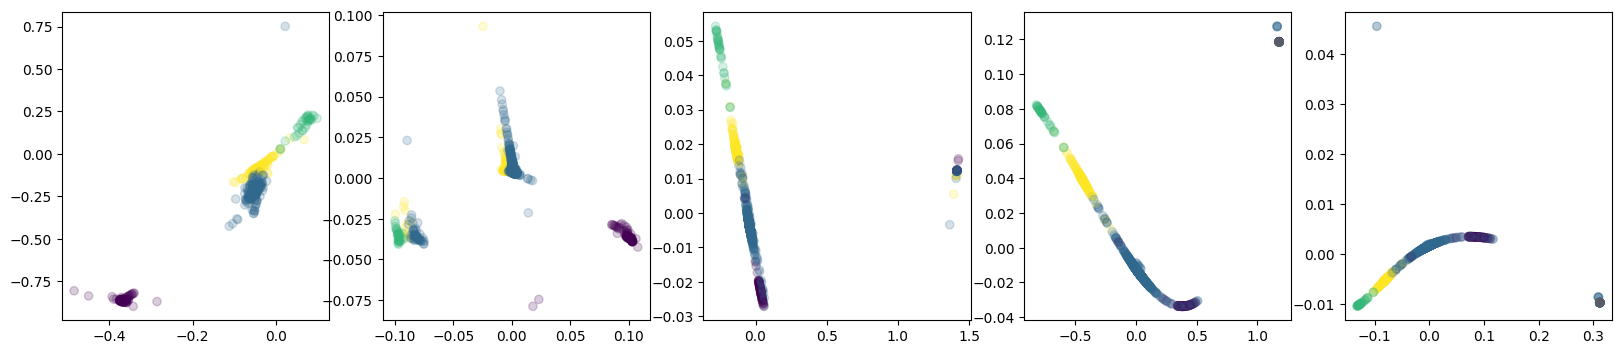

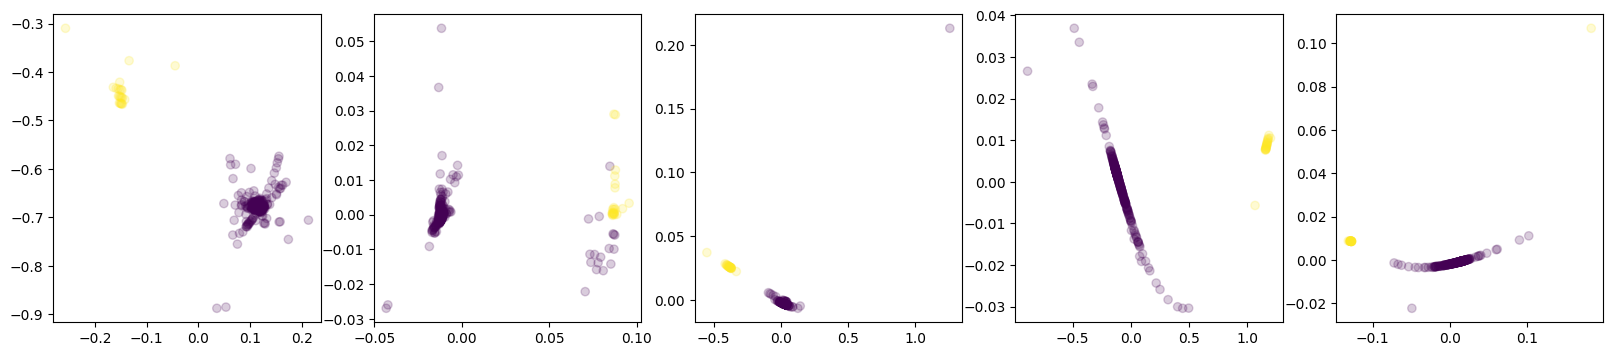

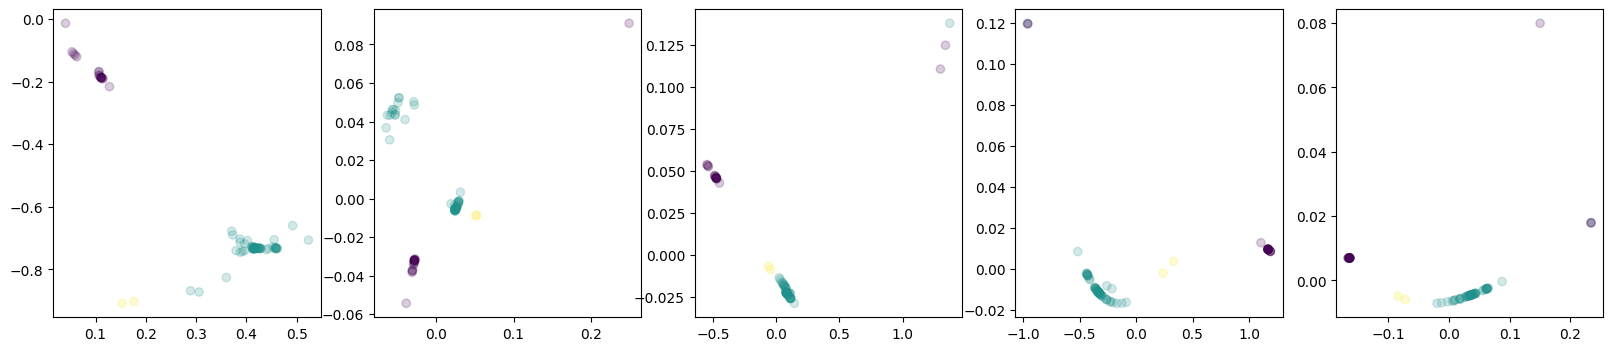

In [15]:
import matplotlib.pyplot as plt
node_counter = 0

for ll in range(0,3):
    graph_eval = graph_list[ll]
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    xj_graph = graph_eval.ndata['pos_hits_norm']
    clr = graph_eval.ndata["particle_number"]
    axs[0].scatter(xj_graph[:,0], xj_graph[:, 1], c=clr.tolist(), alpha=0.2)
    number_of_nodes = graph_eval.number_of_nodes()
    for i in range(0, len(grapsh)):
        s_l = grapsh[i].ndata['s_l'][node_counter:node_counter+number_of_nodes, :]
        pca = PCA(n_components=2)
        PCA_2d_node_feats = pca.fit_transform(s_l.detach().cpu().numpy())
        axs[i+1].scatter(PCA_2d_node_feats[:,0], PCA_2d_node_feats[:,1], c=clr.tolist(), alpha=0.2)
    node_counter = node_counter +number_of_nodes



In [25]:
#/eos/home-g/gkrzmanc/mlpf_data/25_07_2023_norm_knn_FULL_10k/

In [16]:

print(pred.shape)
_, S = pred.shape
xj = pred[:, 0:2]  # 0, 1 : cluster space coords
if xj.shape[1] > 2:
    print("doing PCA")
    pca = PCA(n_components=2)
    xj = pca.fit_transform(xj.detach().cpu().numpy())
    bj = torch.sigmoid(torch.reshape(pred[:, 32], [-1, 1]))
else:
    xj = xj.detach().numpy()
    bj = torch.sigmoid(torch.reshape(pred[:, 2], [-1, 1]))
#
all_embeddings = False
if all_embeddings:
    xj = pred
    pca = PCA(n_components=2)
    xj = pca.fit_transform(xj.detach().cpu().numpy())
#xj = torch.nn.functional.normalize(torch.tensor(xj), dim=1)
xj = torch.tanh(torch.tensor(xj))


torch.Size([6607, 4])


In [17]:
q = (bj.arctanh() ** 2 + 0.1).flatten()

[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]
[1301, 315, 75, 664, 1998, 760, 101, 544, 316, 533]


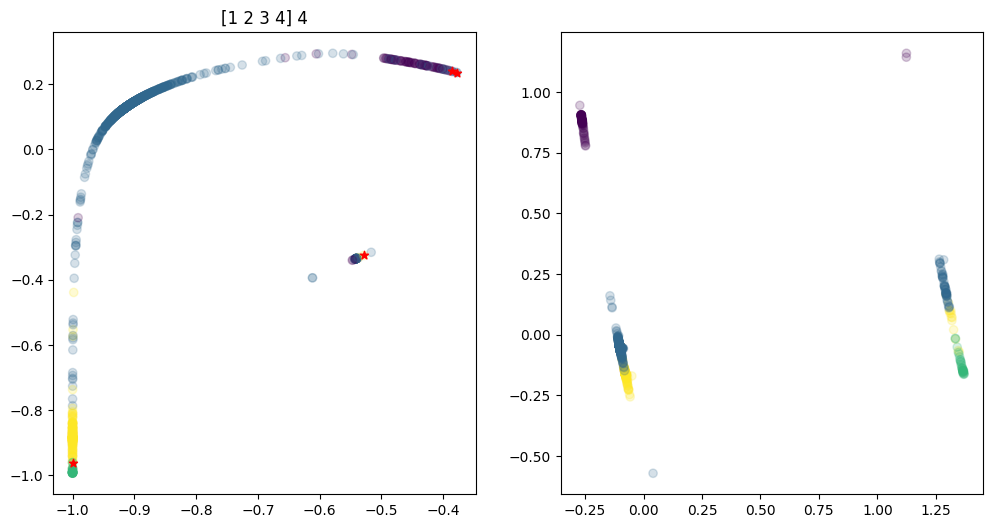

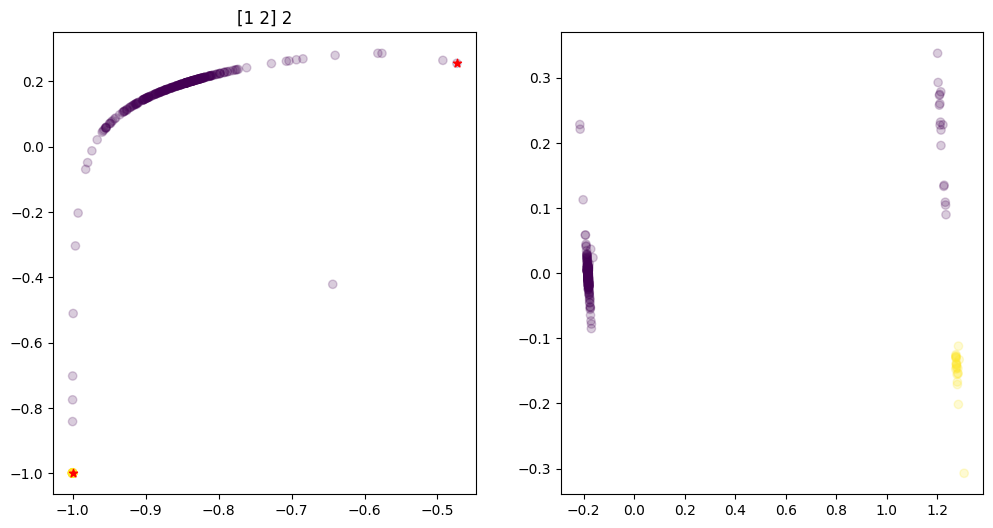

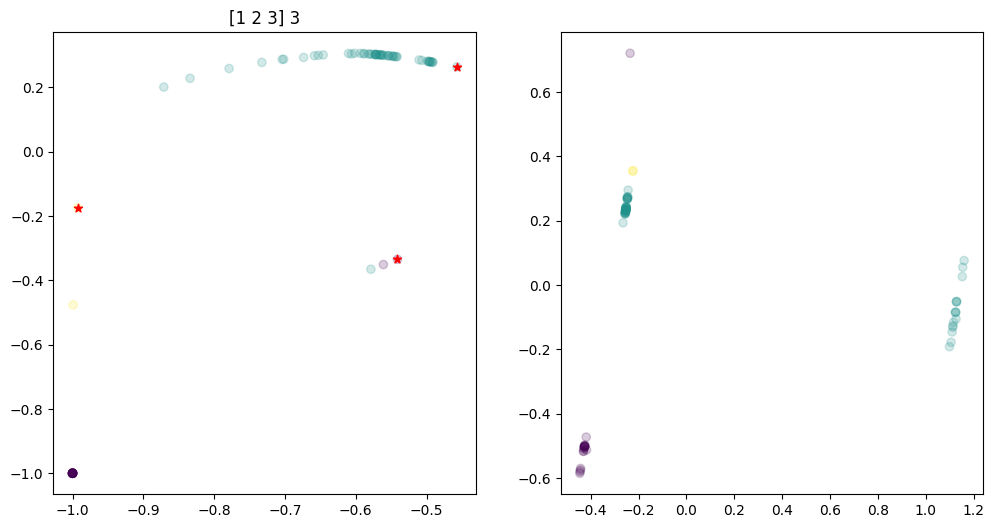

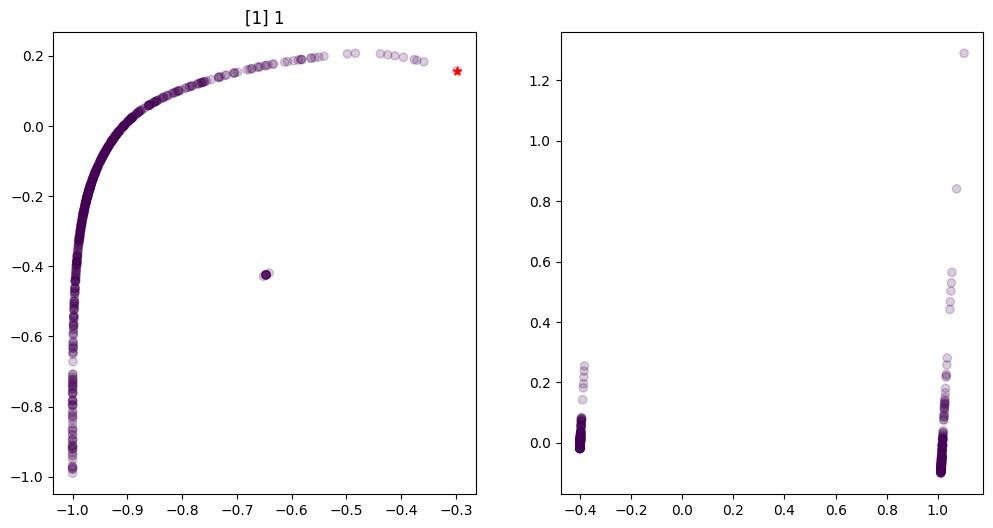

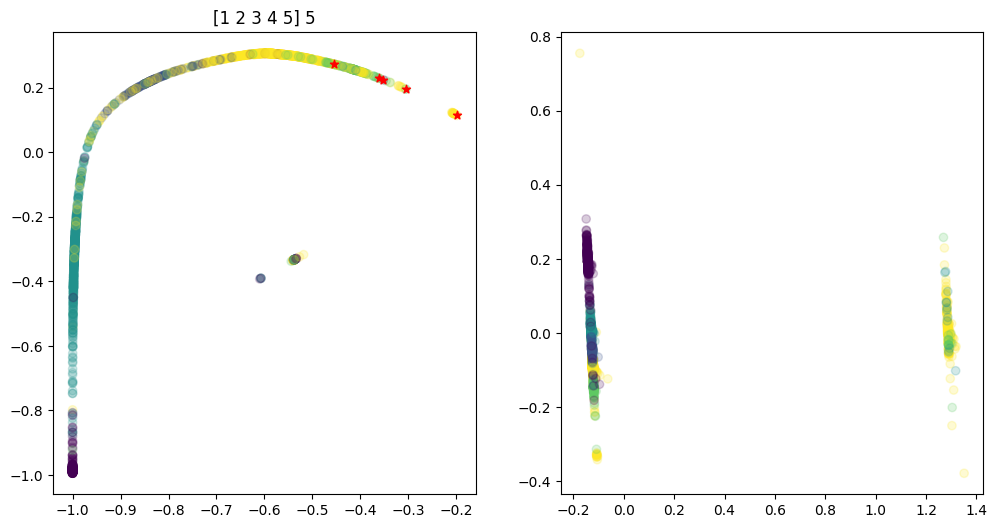

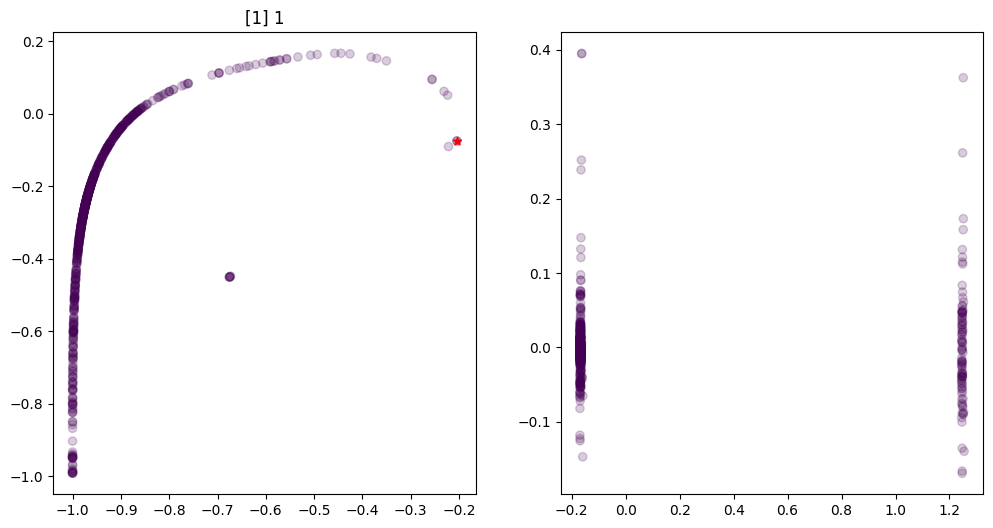

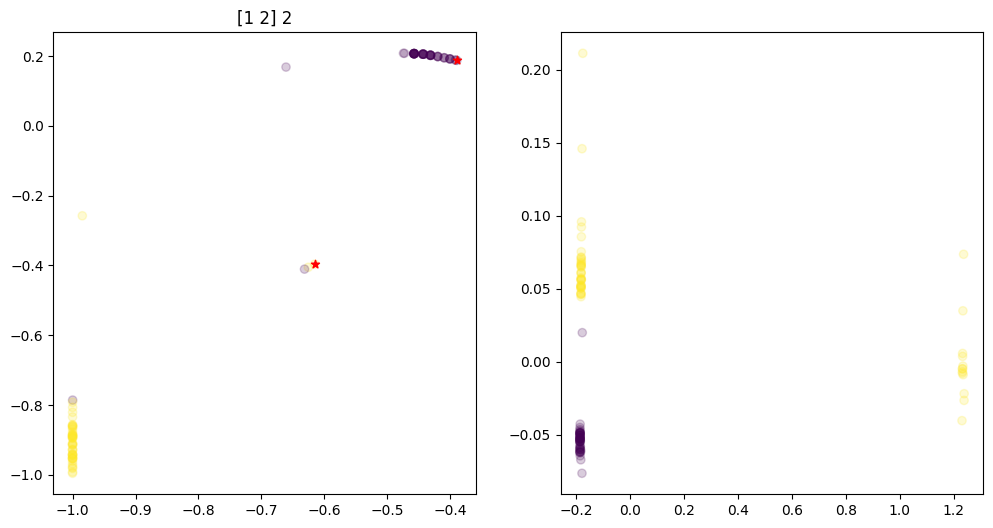

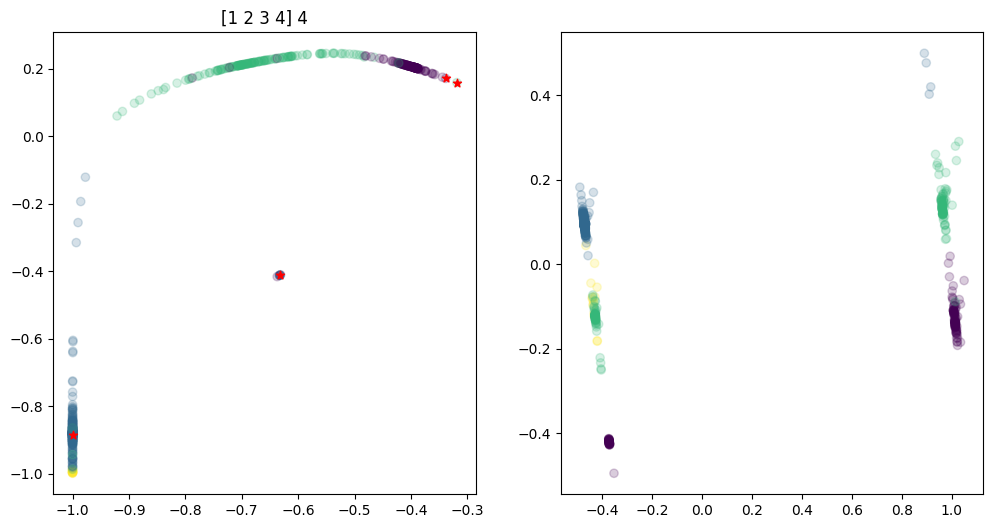

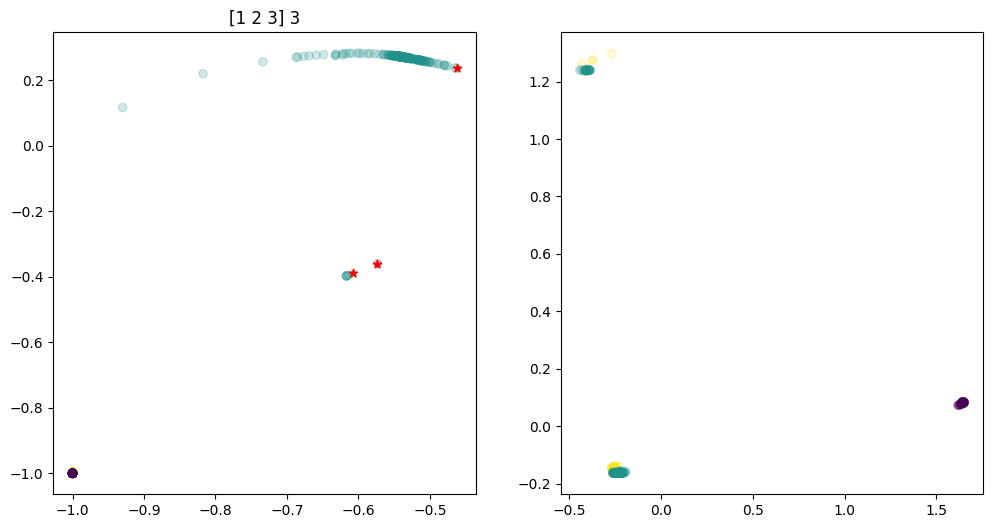

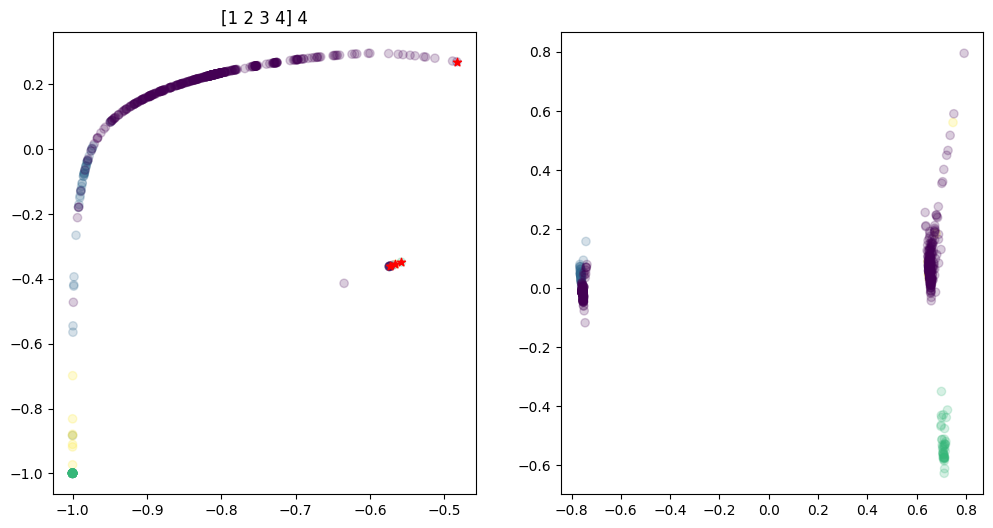

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_scatter import scatter_max, scatter_add, scatter_mean
graph_list = dgl.unbatch(g)
#graph_list = list(train_loader)
#graph_list = [x[0] for x in graph_list]

node_counter = 0
how_many_to_plot = 10

for i in range(how_many_to_plot):
    graph_eval = graph_list[i]
    print([g.num_nodes() for g in graph_list])
    non = graph_eval.number_of_nodes()
    assert non == graph_eval.ndata['h'].shape[0]
    particle_number = graph_eval.ndata['particle_number']
    #if particle_number.max() > 1:
    #    print("skipping one, only plotting events with 2 particles")
    #    continue
    #print(particle_number)
    q_graph = q[node_counter:node_counter+non]
    hit_type = torch.argmax(graph_eval.ndata['hit_type'],dim=1).view(-1)
    PCA_2d_node_feats = PCA(n_components=2).fit_transform(graph_eval.ndata['h'].detach().numpy())
    part_num = graph_eval.ndata['particle_number'].view(-1).to(torch.long)
    q_alpha, index_alpha = scatter_max(q_graph.view(-1), part_num-1)
    #print(part_num.unique())
    xj_graph = xj[node_counter:node_counter+non, :]
    if len(index_alpha) == 1:
        index_alpha = index_alpha.item()
    #print(xj_graph, xj_graph[index_alpha], xj_graph[index_alpha].shape)
    #print(xj_graph.shape, index_alpha.shape, index_alpha)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    clr = graph_eval.ndata["particle_number"]
    axs[0].set_title(str(np.unique(part_num)) + " " + str(len(np.unique(part_num))))
    axs[0].scatter(xj_graph[:,0], xj_graph[:, 1], c=clr.tolist(), alpha=0.2)
    axs[1].scatter(PCA_2d_node_feats[:,0], PCA_2d_node_feats[:,1], c=clr.tolist(), alpha=0.2)
    axs[0].scatter(xj_graph[index_alpha, 0],xj_graph[index_alpha, 1], marker='*', c ="r", alpha=1.)
    pos = graph_eval.ndata['pos_hits_norm']
    node_counter += non


In [206]:
graph_list[0]

Graph(num_nodes=62, num_edges=434,
      ndata_schemes={'h': Scheme(shape=(9,), dtype=torch.float32), 'pos_hits': Scheme(shape=(3,), dtype=torch.float32), 'pos_hits_norm': Scheme(shape=(3,), dtype=torch.float32), 'hit_type': Scheme(shape=(4,), dtype=torch.int64), 'p_hits': Scheme(shape=(1,), dtype=torch.float32), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
i = 1
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
particle_id = graph_eval.ndata['particle_number'].view(-1)
ax.scatter(pos[:,0][particle_id==i], pos[:,1][particle_id==i], pos[:,2][particle_id==i],marker='o', c = hit_type[particle_id==i], alpha=1)

In [ ]:
np.unique(particle_id)